In [303]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import pingouin as pg
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

# Apple 기본 폰트인 'AppleGothic' 사용
mpl.rcParams['font.family'] = 'AppleGothic'

# 음수 기호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

pd.set_option("display.max_columns", None)


In [304]:
# 분석용 편의 함수
def pct(n): return f"{n:.1%}"

# 모든 시간을 XX:00:00 으로 바꾸는 함수.
def round_by_half_hour(td):
    hour = td.components.hours
    minute = td.components.minutes

    if minute < 30:
        return pd.to_timedelta(f"{hour}:00:00")
    else:
        return pd.to_timedelta(f"{hour + 1}:00:00")

In [306]:
df = (
    pd.read_csv("1st-dataset.csv", parse_dates=["game_date"])  # 날짜 파싱
)

sportsType = "전체"

if sportsType in ["야구", "축구", "농구", "배구"]:
    df = df[df['sports_type'] == sportsType]

                  건수     비율
snow_depth      3588  99.0%
precipitation   2931  80.9%
audience        1338  36.9%
death_count      700  19.3%
injury_count     700  19.3%
accident_count   700  19.3%
match_type        21   0.6%
home_team_win      0   0.0%
stadium_code       0   0.0%
start_time         0   0.0%
region             0   0.0%
is_holiday         0   0.0%
day_of_week        0   0.0%
game_date          0   0.0%
temperature        0   0.0%
sports_type        0   0.0%
game_id            0   0.0%


/opt/anaconda3/envs/myFirstProj/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/myFirstProj/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/myFirstProj/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/myFirstProj/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/myFirstProj/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL})

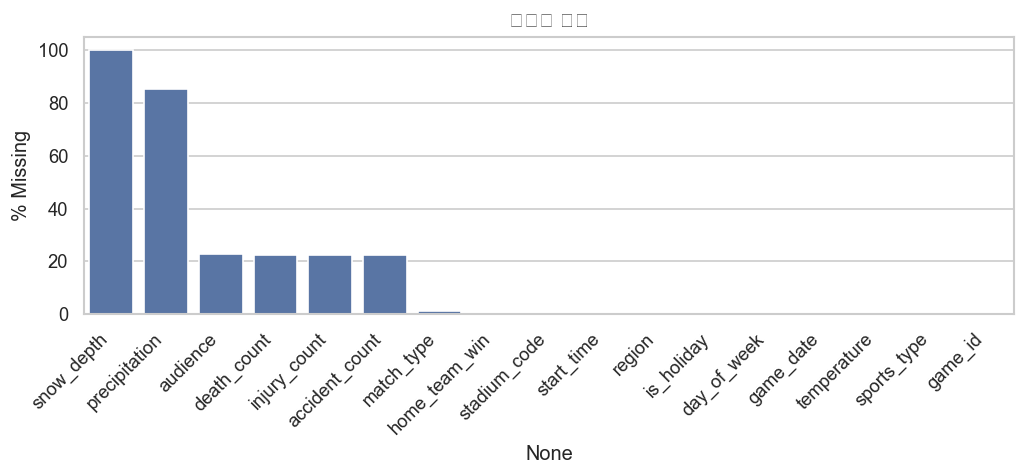

In [307]:
# 결측치 체크
na_cnt   = df.isna().sum()
na_rate  = (na_cnt/len(df)).map(pct)
na_report = pd.concat([na_cnt, na_rate], axis=1, keys=["건수", "비율"])
print(na_report.sort_values("비율", ascending=False))

# 결측치 시각화 ---------------
mpl.rcParams['axes.unicode_minus'] = False  # 음수 기호 깨짐 방지
plt.figure(figsize=(10,3))
sns.barplot(x=na_pct.index, y=na_pct.values)
plt.xticks(rotation=45, ha="right"); plt.ylabel("% Missing")
plt.title("결측치 비율"); plt.show()

In [308]:
## 결측치 처리. 
## 다음 값들은 모두 0 으로 채움
## precipitatione, death_count, injury_count, accident_count, snow_depth     

# 결측치를 0으로 채울 대상 컬럼 목록
cols_to_fill = ["precipitation", "death_count", "injury_count", "accident_count", "snow_depth"]

# 실제 존재하는 컬럼만 선택해 NaN → 0 대체
df.loc[:, df.columns.intersection(cols_to_fill)] = (
    df.loc[:, df.columns.intersection(cols_to_fill)].fillna(0)
)

# 확인
print(df[cols_to_fill].isna().sum())


precipitation     0
death_count       0
injury_count      0
accident_count    0
snow_depth        0
dtype: int64


In [309]:
## match_type 가 결측치 인경우 매년 9월 이전은 '페넌트레이스', 이후는 '플레이오프' 로 명기
# 날짜 컬럼을 날짜형으로 보장 ― 예: 'game_date'
df["game_date"] = pd.to_datetime(df["game_date"], errors="coerce")

# match_type 이 결측(NaN) 또는 빈 문자열("")인 행만 골라 조건부 치환
missing_mask = df["match_type"].isna() | (df["match_type"].astype(str).str.strip() == "")

# 9월 **이전**(1–8월) ⇒ '페넌트레이스'
df.loc[ missing_mask & (df["game_date"].dt.month < 9), "match_type" ] = "페넌트레이스"

# 9월 **이후**(9–12월) ⇒ '플레이오프'
df.loc[ missing_mask & (df["game_date"].dt.month >= 9), "match_type" ] = "플레이오프"

# 결과 확인
print(df["match_type"].value_counts(dropna=False).head())


match_type
페넌트레이스      1914
정규시즌        1025
시범경기         118
플레이오프         64
파이널 라운드B      30
Name: count, dtype: int64


In [310]:

# 기본 치환: '페넌트레이스'·'순위결정전'(오탈자 '순위결정정' 포함)·'0' --> '정규시즌'
df["match_type"] = (
    df["match_type"]
        .replace({"페넌트레이스": "정규시즌",
                  "순위결정전": "정규시즌",
                  "순위결정정": "정규시즌",   # 오타까지 함께 처리
                  '조별리그' : "정규시즌",
                  "0": "정규시즌"})
        # ➋ 라운드 표기(1R ~ 33R 등) → 정규시즌
        .str.replace(r"^\d+R$", "정규시즌", regex=True)
)

df["match_type"] = (
    df["match_type"]
        .replace({'와일드카드':"포스트시즌",
                '준플레이오프':"포스트시즌", 
                '플레이오프':"포스트시즌", 
                '한국시리즈':"포스트시즌",
                '파이널 라운드A':"포스트시즌",
                '파이널 라운드B':"포스트시즌",
                '챔피언결정전':"포스트시즌", 
                '준결승':"포스트시즌", 
                '결승':"포스트시즌",
                '올스타전':"포스트시즌"}
                )
)
# 결과 확인
print(df["match_type"].unique())




['시범경기' '정규시즌' '포스트시즌']


In [311]:
# audience 에 대한 결측치는 각 지역 관중수의 평균에 펴차를 두어 계산
# region별 평균값 계산
# region_mean = df.groupby('region')['audience'].mean()
region_mean = df[df['sports_type'] == '야구'].groupby('region')['audience'].mean()
print(region_mean)

def impute_with_noise(row):
    # print("lod --- 1")
    if pd.isna(row['audience']):
        # print("lod --- 2")
        mean_val = region_mean.get(row['region'], np.nan)
        if pd.notna(mean_val):
            noise = np.random.normal(loc=0, scale=0.1)  # 평균 0, 표준편차 0.1 → ±10% 정도 오차
            return mean_val * (1 + noise)
    return row['audience']

# 4. 적용
df['audience'] = df.apply(impute_with_noise, axis=1)

region
경기 수원시     10694.543750
경기 이천시              NaN
경남 창원시      9285.441718
광주 북구      13906.282051
대구 수성구     16267.680000
대전 중구       9546.604027
부산 동래구     15678.246753
서울 구로구      9815.903846
서울 송파구     16939.218023
울산 남구       8023.300000
인천 미추홀구    15469.792208
충북 청주시      8706.200000
Name: audience, dtype: float64


In [312]:
df["region"] == "경북 구미시"
len(df[df['audience'].isnull()])

520

In [313]:
# 야구인경우 audience가 NaN이인 row 만 가져옴.
cond_baseball = (df['sports_type'] == '야구')  & (df['audience'].isna())
df.loc[cond_baseball, 'audience'] = np.random.randint(5000, 6001, size=cond_baseball.sum())

# 축구의 경우 관중수가 없는 로우는 삭제함.
cond_soccer = (df['sports_type'] == '축구')  & (df['audience'].isna())
df = df[~cond_soccer].copy()

# 배구의 경우 관중수가 없는 로우는 삭제함.
cond_vollyball = (df['sports_type'] == '배구')  & (df['audience'].isna())
df = df[~cond_vollyball].copy()
cond_vollyball_w = (df['sports_type'] == '여자배구')  & (df['audience'].isna())
df = df[~cond_vollyball_w].copy()

# 농구의 경우 해당 조건을 만족하는 행에 관중수를 ~2000 사이 무작위 정수 생성
cond_basketball1 = (df['sports_type'] == '농구') & (df['match_type'] == '정규시즌')
cond_basketball2 = (df['sports_type'] == '농구') & (df['match_type'] == '포스트시즌')
df.loc[cond_basketball1, 'audience'] = np.random.randint(2000, 3001, size=cond_basketball1.sum())
df.loc[cond_basketball2, 'audience'] = np.random.randint(3500, 4200, size=cond_basketball2.sum())





In [314]:
len(df[df['audience'].isnull()])


0

In [315]:
# 문자열을 timedelta64로 변환
df['start_time'] = pd.to_timedelta(df['start_time'])

# 시작시각 → 시간 숫자(0~23) 추출
df["start_hour"] = df['start_time'].dt.components['hours']

In [316]:
# -----------------------------------------------------------
# match_type 기준 ~ accident_count : ANOVA & ETA²
# -----------------------------------------------------------
aov = pg.anova(dv="accident_count", between="match_type", data=df, detailed=True)
print(aov.columns)
eta = aov["np2"][0]
#eta = pg.compute_effsize(df, dv="accident_count", between="match_type", eftype="eta-square")
print("ANOVA\n", aov, "\nETA² =", eta)
#print("ANOVA\n", aov)

print("-----------------------")

# 보너스: 사후검정
posthoc = pairwise_tukeyhsd(df["accident_count"], df["match_type"])
print(posthoc)

Index(['Source', 'SS', 'DF', 'MS', 'F', 'p-unc', 'np2'], dtype='object')
ANOVA
        Source            SS    DF         MS         F     p-unc       np2
0  match_type    154.323315     2  77.161658  3.903007  0.020272  0.002296
1      Within  67059.148260  3392  19.769796       NaN       NaN       NaN 
ETA² = 0.0022960176263616757
-----------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  시범경기   정규시즌   0.9029 0.0774 -0.0748 1.8806  False
  시범경기  포스트시즌   1.5116 0.0146  0.2414 2.7817   True
  정규시즌  포스트시즌   0.6086 0.2155 -0.2441 1.4614  False
---------------------------------------------------


In [317]:
# -----------------------------------------------------------
# 휴일 기준 ~ accident_count : ANOVA & ETA²
# -----------------------------------------------------------
aov = pg.anova(dv="accident_count", between="is_holiday", data=df, detailed=True)
print(aov.columns)
eta = aov["np2"][0]
#eta = pg.compute_effsize(df, dv="accident_count", between="match_type", eftype="eta-square")
print("ANOVA\n", aov, "\nETA² =", eta)
#print("ANOVA\n", aov)

print("-----------------------")

# 보너스: 사후검정
posthoc = pairwise_tukeyhsd(df["accident_count"], df["is_holiday"])
print(posthoc)

Index(['Source', 'SS', 'DF', 'MS', 'F', 'p-unc', 'np2'], dtype='object')
ANOVA
        Source            SS    DF          MS          F     p-unc       np2
0  is_holiday    459.002280     1  459.002280  23.330194  0.000001  0.006829
1      Within  66754.469295  3393   19.674173        NaN       NaN       NaN 
ETA² = 0.006829022065197812
-----------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1  -0.7403   0.0 -1.0408 -0.4398   True
---------------------------------------------------


In [318]:
# -----------------------------------------------------------
# 요일 기준 ~ accident_count : ANOVA & ETA²
# -----------------------------------------------------------
aov = pg.anova(dv="accident_count", between="day_of_week", data=df, detailed=True)
print(aov.columns)
eta = aov["np2"][0]
#eta = pg.compute_effsize(df, dv="accident_count", between="match_type", eftype="eta-square")
print("ANOVA\n", aov, "\nETA² =", eta)
#print("ANOVA\n", aov)

print("-----------------------")

# 보너스: 사후검정
posthoc = pairwise_tukeyhsd(df["accident_count"], df["day_of_week"])
print(posthoc)

Index(['Source', 'SS', 'DF', 'MS', 'F', 'p-unc', 'np2'], dtype='object')
ANOVA
         Source            SS    DF          MS         F         p-unc  \
0  day_of_week    937.609082     6  156.268180  7.988377  1.405685e-08   
1       Within  66275.862494  3388   19.561943       NaN           NaN   

       np2  
0  0.01395  
1      NaN   
ETA² = 0.013949719599998219
-----------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     금      목  -0.5245 0.5444 -1.3816  0.3326  False
     금      수  -0.0188    1.0 -0.8797  0.8421  False
     금      월  -0.3754 0.9844 -1.7488   0.998  False
     금      일  -1.3416    0.0 -2.1196 -0.5637   True
     금      토  -0.1166 0.9994  -0.893  0.6599  False
     금      화   0.0651    1.0 -0.7879  0.9181  False
     목      수   0.5057 0.5957 -0.3566   1.368  False
     목      월   0.1491 0.9999 -1.2252  1.5233  False
     목      일  -0.8171

In [319]:
# -----------------------------------------------------------
# 홈팀 승패 여부 ~ accident_count : ANOVA & ETA²
# -----------------------------------------------------------
aov = pg.anova(dv="accident_count", between="home_team_win", data=df, detailed=True)
print(aov.columns)
eta = aov["np2"][0]
#eta = pg.compute_effsize(df, dv="accident_count", between="match_type", eftype="eta-square")
print("ANOVA\n", aov, "\nETA² =", eta)
#print("ANOVA\n", aov)

print("-----------------------")

# 보너스: 사후검정
posthoc = pairwise_tukeyhsd(df["accident_count"], df["home_team_win"])
print(posthoc)

Index(['Source', 'SS', 'DF', 'MS', 'F', 'p-unc', 'np2'], dtype='object')
ANOVA
           Source            SS    DF         MS         F    p-unc       np2
0  home_team_win      0.249496     1   0.249496  0.012595  0.91065  0.000004
1         Within  67213.222079  3393  19.809379       NaN      NaN       NaN 
ETA² = 3.711999542005505e-06
-----------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.0171 0.9107 -0.2824 0.3167  False
---------------------------------------------------


In [320]:
# 중복성 제거
dup_rows = df.duplicated().sum()
dup_keys = df.duplicated(subset=["game_date","region","game_id"], keep=False).sum()

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3395 entries, 0 to 3622
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   game_id         3395 non-null   int64          
 1   stadium_code    3395 non-null   object         
 2   sports_type     3395 non-null   object         
 3   game_date       3395 non-null   datetime64[ns] 
 4   day_of_week     3395 non-null   object         
 5   is_holiday      3395 non-null   int64          
 6   start_time      3395 non-null   timedelta64[ns]
 7   home_team_win   3395 non-null   int64          
 8   match_type      3395 non-null   object         
 9   audience        3395 non-null   float64        
 10  region          3395 non-null   object         
 11  accident_count  3395 non-null   float64        
 12  injury_count    3395 non-null   float64        
 13  death_count     3395 non-null   float64        
 14  temperature     3395 non-null   float64      

In [321]:
# 범주형 Cardinality & 정제
for col in ["sports_type", "day_of_week", "match_type", "is_holiday", "region"]:
    print(df[col].value_counts(dropna=False).head(20), "\n")


sports_type
야구      2072
농구       563
축구       418
배구       267
여자배구      75
Name: count, dtype: int64 

day_of_week
토    719
일    712
화    471
금    465
목    462
수    454
월    112
Name: count, dtype: int64 

match_type
정규시즌     3120
포스트시즌     157
시범경기      118
Name: count, dtype: int64 

is_holiday
0    1892
1    1503
Name: count, dtype: int64 

region
서울 송파구     525
경기 수원시     407
경남 창원시     283
대전 중구      280
부산 동래구     252
광주 북구      211
인천 미추홀구    205
대구 수성구     187
서울 구로구     180
대구 동구       89
울산 중구       58
경기 안양시      58
강원 원주시      55
경기 고양시      54
울산 남구       50
전북 전주시      50
경기 안산시      41
인천 계양구      40
서울 중구       40
충남 천안시      39
Name: count, dtype: int64 



In [322]:
# 필요 변수 One-Hot Encoding 진행
df_encoded = pd.get_dummies(df, columns=['match_type'], prefix='match', drop_first=False)
df_encoded = pd.get_dummies(df_encoded, columns=['sports_type'], prefix='type', drop_first=False)

df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3395 entries, 0 to 3622
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   game_id         3395 non-null   int64          
 1   stadium_code    3395 non-null   object         
 2   game_date       3395 non-null   datetime64[ns] 
 3   day_of_week     3395 non-null   object         
 4   is_holiday      3395 non-null   int64          
 5   start_time      3395 non-null   timedelta64[ns]
 6   home_team_win   3395 non-null   int64          
 7   audience        3395 non-null   float64        
 8   region          3395 non-null   object         
 9   accident_count  3395 non-null   float64        
 10  injury_count    3395 non-null   float64        
 11  death_count     3395 non-null   float64        
 12  temperature     3395 non-null   float64        
 13  precipitation   3395 non-null   float64        
 14  snow_depth      3395 non-null   float64      

In [323]:
# csv 로 1차 데이타셋 저장
dataset_filename = f"1st-dataset-prepressed-{sportsType}.csv"
df_encoded.to_csv(dataset_filename, index=False, encoding='utf-8')

In [ ]:
num_cols = ["accident_count","injury_count","death_count"]
desc = df[num_cols].describe().T   # min-max, IQR
q1,q3 = df["accident_count"].quantile([.25,.75])
iqr   = q3-q1
out   = df[(df["accident_count"] < q1-1.5*iqr) | (df["accident_count"] > q3+1.5*iqr)]

In [ ]:
# 상관관계·다중공선성 확인
corr = df.corr(numeric_only=True)
target_corr = corr["accident_count"].sort_values(ascending=False)
# print(corr)
print(target_corr)

accident_count    1.000000
injury_count      0.943465
start_hour        0.107631
death_count       0.093535
game_id           0.016578
home_team_win     0.014736
temperature      -0.001184
precipitation    -0.033496
is_holiday       -0.097880
audience               NaN
snow_depth             NaN
Name: accident_count, dtype: float64


In [ ]:
# from ydata_profiling import ProfileReport
# ProfileReport(df, title="1차 데이터셋 품질 리포트").to_file("eda_quality_report.html")

ModuleNotFoundError: No module named 'ydata_profiling'